In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-7o0uuq_6 because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Dataset

In [2]:
dataset_dim = 2
num_rand_samples = 16
num_unif_samples = 16
num_samples = num_rand_samples+num_unif_samples
noise_size = 0.2

In [3]:
np.random.seed(1)
ts = np.random.normal(3*np.pi/2,np.pi/3,num_rand_samples)
ts = np.concatenate((ts,np.linspace(5 * np.pi/6, 13 * np.pi / 6, num_unif_samples)))
xs = np.cos(ts) * (1+ noise_size * np.exp((-(ts-(3*np.pi/2))**2)/2) * np.random.normal(size=num_samples))
ys = np.sin(ts) * (1+ noise_size * np.exp((-(ts-(3*np.pi/2))**2)/2) * np.random.normal(size=num_samples))
dataset = np.hstack((xs[:,np.newaxis],ys[:,np.newaxis])) * 1000

(-1056.2042446202956,
 1101.1535983509552,
 -1234.039516750181,
 835.4409579453084)

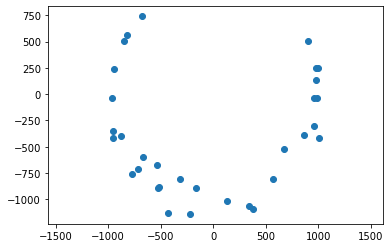

In [4]:
plt.scatter(dataset[:,0],dataset[:,1])
plt.axis("equal")
#plt.plot(np.cos(np.arange(0,100,0.01)),np.sin(np.arange(0,100,0.01)))

# 1D VAE Fit to Dataset

In [5]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device, alldata=False):
    """Sample Pair of Points from Trajectory"""
    if alldata:
        if batchsize is not None:
            raise "don't pass in batchsize if you're doing all data"
        traj_ids = range(all_points.shape[0])
        t1_ids = [0]
        t2_ids = t1_ids
    else:
        # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
        traj_ids = np.random.choice(all_points.shape[0], batchsize)
        t1_ids = np.random.choice(all_points.shape[1], batchsize)
        if predictive:
            t2_ids = np.random.choice(all_points.shape[1], batchsize)
        else:
            t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [6]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cuda"
train_loader = Loader(dataset[:,np.newaxis,:], 256, 0,10,predictive=False, device=device)
    

In [7]:
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [8]:
testname = "pedagogical/swiss2d"

In [9]:
all_models=[]
all_exceptions = []
for beta in [1,10,0.1,0.01,0.001]:
    for curvreg in [0]:#,1,10,100,1000]:
        secreg = 0
        if curvreg != 0 and secreg != 0:
            continue
        for latentdim in [1]:
            for epsilon_scale_start in [2]:
                try:
                    vae = make_vae(latent_dim=latentdim).to(device)
                    num_epochs = 1000
                    savedir  = f'{testname}_lat{latentdim}_secreg{secreg}_curvreg{curvreg}_beta{beta}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
                    print(savedir)
                    trainer = ppttrainer.PPTVAETrainer(vae, train_loader, beta=beta, device=device,
                        log_dir=savedir, lr=0.001, annealingBatches=0, record_loss_every=50, loss_func = "gaussian")
                    scheduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=0.5)
                    epoch = 0
                    epsilon_scale = epsilon_scale_start
                    for _ in range(num_epochs*3):
                        epoch+=1
                        # had an off-by-one error here before
                        # update values BEFORE training 501st element
                        if epoch % num_epochs == 1 and epoch > 1: 
                            scheduler.step()
                        embst = trainer.train(second_deriv_regularizer=secreg, curvature_regularizer=curvreg, epsilon_scale = epsilon_scale, num_new_samp_points=128)
                        is_error = embst[0]
                        if is_error:
                            raise Exception
                    sm.save_fcpassthrough_vae(vae, savedir)
                    print(savedir)
                    all_models.append(savedir)
                except:
                    raise

pedagogical/swiss2d_lat1_secreg0_curvreg0_beta1_20220204-162634
pedagogical/swiss2d_lat1_secreg0_curvreg0_beta1_20220204-162634
pedagogical/swiss2d_lat1_secreg0_curvreg0_beta10_20220204-162944
pedagogical/swiss2d_lat1_secreg0_curvreg0_beta10_20220204-162944
pedagogical/swiss2d_lat1_secreg0_curvreg0_beta0.1_20220204-163251
pedagogical/swiss2d_lat1_secreg0_curvreg0_beta0.1_20220204-163251
pedagogical/swiss2d_lat1_secreg0_curvreg0_beta0.01_20220204-163600
pedagogical/swiss2d_lat1_secreg0_curvreg0_beta0.01_20220204-163600
pedagogical/swiss2d_lat1_secreg0_curvreg0_beta0.001_20220204-163908
pedagogical/swiss2d_lat1_secreg0_curvreg0_beta0.001_20220204-163908


In [10]:

colors=["red","yellow","green","orange","black","gray","blue"]

In [11]:

import importlib
importlib.reload(lm)

for i, modelpath in enumerate(all_models):
    print(modelpath)
    vae = lm.load_model(modelpath)

pedagogical/swiss2d_lat1_secreg0_curvreg0_beta1_20220204-162634
pedagogical/swiss2d_lat1_secreg0_curvreg0_beta10_20220204-162944
pedagogical/swiss2d_lat1_secreg0_curvreg0_beta0.1_20220204-163251
pedagogical/swiss2d_lat1_secreg0_curvreg0_beta0.01_20220204-163600
pedagogical/swiss2d_lat1_secreg0_curvreg0_beta0.001_20220204-163908


pedagogical/swiss2d_lat1_secreg0_curvreg0_beta1_20220204-162634
pedagogical/swiss2d_lat1_secreg0_curvreg0_beta10_20220204-162944
pedagogical/swiss2d_lat1_secreg0_curvreg0_beta0.1_20220204-163251
pedagogical/swiss2d_lat1_secreg0_curvreg0_beta0.01_20220204-163600
pedagogical/swiss2d_lat1_secreg0_curvreg0_beta0.001_20220204-163908


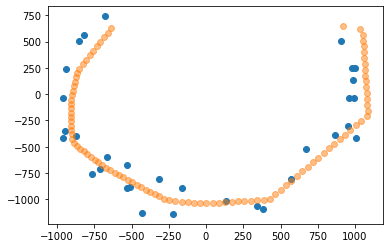

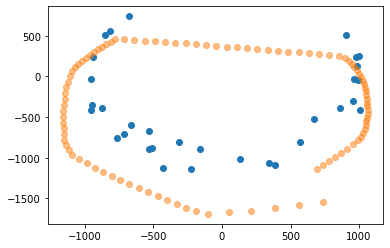

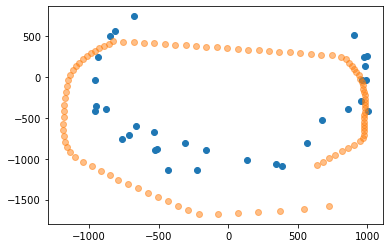

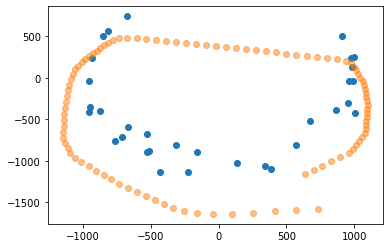

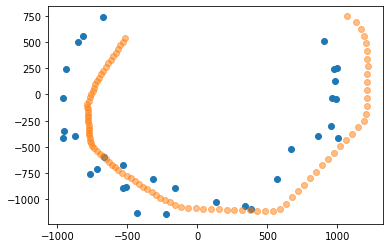

In [12]:

for i, modelpath in enumerate(all_models):
    fig = plt.figure()
    print(modelpath)
    vae = lm.load_model(modelpath)
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0].detach().cpu().numpy()
    pts = np.linspace(np.min(embeds[:,0]),np.max(embeds[:,0]),100).reshape((-1,1))
    readout = vae.decode(torch.tensor(pts,dtype=torch.float),
              torch.tensor(np.zeros((len(pts),0)),dtype=torch.float))[0].detach().cpu()
    
    plt.scatter(dataset[:,0],dataset[:,1]);
    plt.scatter(readout[:,0],readout[:,1], alpha=0.5);